In [1]:
import os
from pathlib import Path
import rasterio
import numpy as np

import random
import torch
from typing import Tuple, Dict, Any
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
import cv2

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
from rasterio.errors import NotGeoreferencedWarning
from tqdm.notebook import tqdm

from torch.amp import autocast, GradScaler

from PIL import Image
from torchvision import transforms

In [2]:
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

# Подготовка датасета

## Разделение изображений на патчи

In [3]:
def split_image_into_patches(
    image_path, 
    mask_path, 
    output_dir, 
    patch_size=1024, 
    stride=1024
):
    """
    Разделяет большое изображение и маску на перекрывающиеся патчи
    """
    output_dir = Path(output_dir)
    images_dir = output_dir / "images"
    masks_dir = output_dir / "gt"
    images_dir.mkdir(parents=True, exist_ok=True)
    masks_dir.mkdir(parents=True, exist_ok=True)
    
    # Чтение изображения и маски
    with rasterio.open(image_path) as src:
        image = src.read()  # [C, H, W]
        profile = src.profile
    
    with rasterio.open(mask_path) as src:
        mask = src.read(1)  # [H, W]
    
    _, h, w = image.shape
    
    patch_count = 0
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            # Вырезаем патч
            image_patch = image[:, y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            
            # Сохраняем патч изображения
            patch_name = f"{Path(image_path).stem}_patch_{y}_{x}.tif"
            patch_path = images_dir / patch_name
            
            profile.update({
                'height': patch_size,
                'width': patch_size,
                'count': image.shape[0]
            })
            
            with rasterio.open(patch_path, 'w', **profile) as dst:
                dst.write(image_patch)
            
            # Сохраняем патч маски
            mask_patch_path = masks_dir / patch_name
            profile.update({
                'count': 1,
                'dtype': rasterio.uint8
            })
            
            with rasterio.open(mask_patch_path, 'w', **profile) as dst:
                dst.write(mask_patch.astype(np.uint8), 1)
            
            patch_count += 1
    
    return patch_count

In [4]:
def prepare_dataset(
    data_root="./data",
    patch_size=1024, 
    stride=1024
):
    """
    Подготовка полного датасета: разделение всех изображений на патчи
    """
    data_root = Path(data_root)
    train_images_dir = data_root / "AerialImageDataset" / "train" / "images"
    train_masks_dir = data_root / "AerialImageDataset" / "train" / "gt"
    train_output_dir = data_root / "train_patches"
    
    # Обработка train данных
    print("Разделение train изображений на патчи...")
    image_files = list(train_images_dir.glob("*.tif"))
    
    total_patches = 0
    for img_path in tqdm(image_files):
        mask_path = train_masks_dir / img_path.name
        if mask_path.exists():
            patches = split_image_into_patches(
                img_path, mask_path, train_output_dir, 
                patch_size, stride
            )
            total_patches += patches
    
    print(f"Создано {total_patches} тренировочных патчей")

In [5]:
prepare_dataset()

Разделение train изображений на патчи...


  0%|          | 0/180 [00:00<?, ?it/s]

Создано 2880 тренировочных патчей


## Трансформации

In [7]:
class ScaleAwareAugmentation:
    def __init__(self, base_scale=0.3, patch_size=256, zoom_factors=None, is_train=True):
        self.base_scale = base_scale
        self.patch_size = patch_size
        self.zoom_factors = zoom_factors if zoom_factors is not None else (0.25, 2.0)
        self.is_train = is_train
        
        if is_train:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=1.0),
                    A.RandomGamma(p=1.0),
                ], p=0.5),
                A.GaussNoise(p=0.2),
                A.Blur(blur_limit=3, p=0.2),
            ])
        else:
            self.transform = A.Compose([])
    
    def apply_zoom(self, image, mask, zoom_factor):
        """Применение зума с гарантией совпадения размеров"""
        h, w = image.shape[:2]
        
        # Выбираем трансформацию в зависимости от зума
        transform = A.Compose([
            A.Resize(height=int(h * zoom_factor), width=int(w * zoom_factor)),
            A.RandomCrop(height=self.patch_size, width=self.patch_size)
        ])
        
        if mask is not None:
            transformed = transform(image=image, mask=mask)
            return transformed['image'], transformed['mask']
        else:
            transformed = transform(image=image)
            return transformed['image'], None
    
    def __call__(self, image, mask=None):
        """
        Возвращает: image, mask, scale
        """
        if self.zoom_factors is not None:
            zoom_factor = random.uniform(self.zoom_factors[0], self.zoom_factors[1])
            image, mask = self.apply_zoom(image, mask, zoom_factor)
            actual_scale = self.base_scale / zoom_factor
        else:
            actual_scale = self.base_scale

        if self.is_train:
            # Применяем остальные аугментации
            transformed = self.transform(image=image, mask=mask)
            actual_scale = self.base_scale / zoom_factor
            return transformed['image'], transformed['mask'], actual_scale
        else:
            # Для валидации: просто применяем трансформы
            transformed = self.transform(image=image, mask=mask)
            return transformed['image'], transformed['mask'], actual_scale

## Dataset и dataloader

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, data_root, split="train", transform=None, base_scale=0.3, 
                 weight_params=None, distance_transform_weights=False):
        """
        Args:
            data_root: Корневая папка с данными
            split: 'train' или 'test'
            transform: объект ScaleAwareAugmentation
            base_scale: базовый масштаб в метрах на пиксель
            weight_params: параметры для расчета весов {'alpha': 2.0, 'beta': 2.0}
            precompute_weights: сохранять ли веса на диск (True) или считать на лету (False)
        """
        self.data_root = Path(data_root)
        self.split = split
        self.transform = transform
        self.base_scale = base_scale
        self.weight_params = weight_params or {'alpha': 2.0, 'beta': 1.0}
        self.distance_transform_weights = distance_transform_weights
        
        # Пути к патчам
        if split == "test":
            self.images_dir = self.data_root / "AerialImageDataset" / "test" / "images"
            self.masks_dir = None
        else:
            self.images_dir = self.data_root / "train_patches" / "images"
            self.masks_dir = self.data_root / "train_patches" / "gt"
        
        # Список файлов
        self.image_files = sorted(list(self.images_dir.glob("*.tif")))
        
        if len(self.image_files) == 0:
            raise RuntimeError(f"Не найдены изображения в {self.images_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def compute_distance_weights(self, mask):
        """Вычисляет веса на основе Distance Transform"""
        # Убеждаемся, что маска бинарная
        mask_bin = (mask > 0).astype(np.uint8)
        
        # Вычисляем расстояние до границ объекта
        dist_in = cv2.distanceTransform(mask_bin, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
        
        # Вычисляем расстояние до границ фона
        dist_out = cv2.distanceTransform(1 - mask_bin, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
        
        # Комбинированная карта расстояний (на границах = 0)
        dist_map = dist_in + dist_out
        
        # Параметры весов
        alpha = self.weight_params['alpha']
        beta = self.weight_params['beta']
        
        # Веса: экспоненциальное увеличение близко к границам
        weights = alpha * np.exp(-beta * dist_map)
        
        # Нормализация
        weights = weights * (alpha / (weights.max() + 1e-8)) + 1
        
        return weights.astype(np.float32)

    def __getitem__(self, idx):
        # Загрузка изображения
        image_path = self.image_files[idx]
        
        with rasterio.open(image_path) as src:
            image = src.read()  # [C, H, W]
            image = np.transpose(image, (1, 2, 0))  # [H, W, C]
        
        # Загрузка маски и весов для train
        mask = None
        weights = None
        
        if self.split != "test" and self.masks_dir:
            mask_path = self.masks_dir / image_path.name
            with rasterio.open(mask_path) as src:
                mask = src.read(1)  # [H, W]
            
            # Применение аугментаций (синхронно для image, mask)
            if self.transform:
                image, mask, scale = self.transform(image, mask)
                if self.distance_transform_weights:
                    weights = self.compute_distance_weights(mask)
            else:
                scale = self.base_scale
        else:
            # Для теста веса не нужны
            if self.transform:
                image, _, scale = self.transform(image, None)
            else:
                scale = self.base_scale
        # Нормализация изображения
        image = image.astype(np.float32)
        image = image / 255.0
        # mean = [0.485, 0.456, 0.406]  # ImageNet статистика
        # std = [0.229, 0.224, 0.225]
        # image = (image - mean) / std
        
        # Приведение к тензорам
        image = np.transpose(image, (2, 0, 1))  # [C, H, W]
        image = torch.from_numpy(image).float()
        
        if mask is not None:
            mask = mask.astype(np.float32)
            mask = (mask > 0).astype(np.float32)
            mask = torch.from_numpy(mask).unsqueeze(0)  # [1, H, W]
            if self.distance_transform_weights:
                weights = weights.astype(np.float32)
                weights = torch.from_numpy(weights).unsqueeze(0)  # [1, H, W]
        
        # Для test возвращаем только изображение и масштаб
        if self.split == "test":
            return image, scale, str(image_path)
        if self.distance_transform_weights:
            return image, mask, weights, scale
        else:
            return image, mask, scale

In [ ]:
def create_dataloaders(
    data_root="./data",
    batch_size=4,
    num_workers=0,
    patch_size=256,
    base_scale=0.3,
    zoom_factors=None,
    val_zoom_factors=None,
    distance_transform_weights=False
):
    """
    Создание train и val dataloaders
    """
    # Аугментации для обучения
    train_transform = ScaleAwareAugmentation(
        base_scale=base_scale,
        patch_size=patch_size,
        zoom_factors=zoom_factors,
        is_train=True
    )
    
    # Трансформы для валидации (без аугментаций)
    val_transform = ScaleAwareAugmentation(
        base_scale=base_scale,
        patch_size=1024 if val_zoom_factors is None else patch_size,
        is_train=False,
        zoom_factors=val_zoom_factors
    )
    
    # Создание датасетов
    train_dataset = SatelliteDataset(
        data_root=data_root,
        split="train",
        transform=train_transform,
        base_scale=base_scale,
        distance_transform_weights=distance_transform_weights
    )
    
    # Для валидации можно использовать 15% train данных
    train_size = int(0.85 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    
    train_subset, val_subset = random_split(
        train_dataset, [train_size, val_size]
    )
    # Присваиваем валидационный трансформ
    val_subset.dataset = SatelliteDataset(
        data_root=data_root,
        split="train",
        transform=val_transform,
        base_scale=base_scale
    )
    
    # DataLoaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader

In [10]:
def visualize_batch(images, masks, weights, scales):
    """
    Визуализация первых 4 примеров из батча
    Структура: 3 строки (изображения, маски, веса) x 4 колонки (примеры)
    """
    # Берем только первые 4 примера
    batch_size = min(4, len(images))
    
    fig, axes = plt.subplots(3, batch_size, figsize=(batch_size * 4, 10))
    
    if batch_size == 1:
        axes = axes.reshape(3, 1)
    
    for i in range(batch_size):
        # Первая строка: оригинальные изображения
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Изображение\n(scale: {scales[i]:.3f} м/пиксель)", fontsize=10)
        axes[0, i].axis('off')
        
        # Вторая строка: маски
        mask = masks[i].cpu().numpy().squeeze()
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title("Маска\nзданий", fontsize=10)
        axes[1, i].axis('off')
        
        # Третья строка: веса (карта расстояний)
        weight = weights[i].cpu().numpy().squeeze()
        im = axes[2, i].imshow(weight, vmin=1, vmax=3)
        axes[2, i].set_title(f"Веса\n(DT weights)", fontsize=10)
        axes[2, i].axis('off')
        
        # Добавляем colorbar для весов
        plt.colorbar(im, ax=axes[2, i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

In [11]:
zoom_factors = (0.25, 2.0)

# Создание даталоадеров

train_loader, val_loader = create_dataloaders(
    data_root="./data",
    batch_size=8,
    patch_size=256,
    num_workers=0,
    base_scale=0.3,
    zoom_factors=zoom_factors,
    distance_transform_weights=True
)
    
# Просмотр одного батча
print(f"Количество тренировочных батчей: {len(train_loader)}")

Количество тренировочных батчей: 306


In [12]:
# Получаем первый батч
for images, masks, weights, scales in train_loader:
    print(f"Размер изображений: {images.shape}")
    print(f"Размер масок: {masks.shape}")
    print(f"Размер весов: {weights.shape}")
    print(f"Масштабы: {scales}")
    break

Размер изображений: torch.Size([8, 3, 256, 256])
Размер масок: torch.Size([8, 1, 256, 256])
Размер весов: torch.Size([8, 1, 256, 256])
Масштабы: tensor([0.6098, 0.3505, 0.1729, 0.2958, 0.2296, 0.1537, 0.2020, 0.2100],
       dtype=torch.float64)


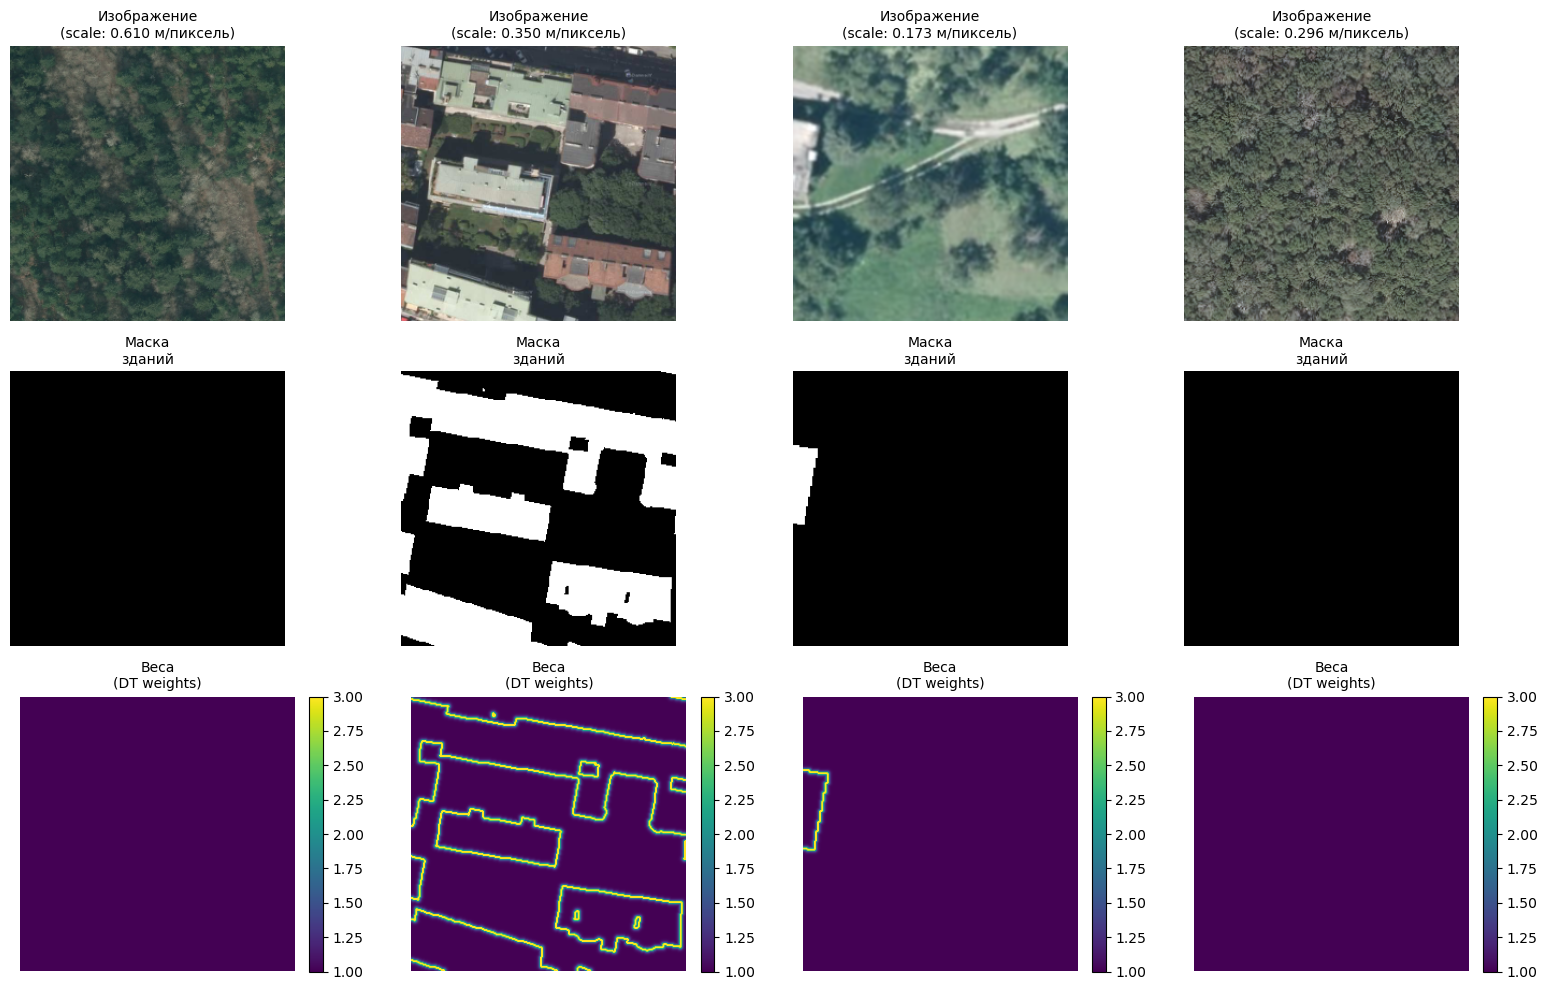

In [13]:
# Визуализация
visualize_batch(images, masks, weights, scales)

In [14]:
# Создание тест датасета
test_dataset = SatelliteDataset(
    data_root="./data",
    split="test",
    transform=None,
    base_scale=0.3
)
    
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)
    
print(f"Количество тестовых изображений: {len(test_dataset)}")
    
# Пример использования тестового даталоадера
for image, scale, path in test_loader:
    print(f"Тестовое изображение: {image.shape}, масштаб: {scale}")
    break

Количество тестовых изображений: 180
Тестовое изображение: torch.Size([1, 3, 5000, 5000]), масштаб: tensor([0.3000], dtype=torch.float64)


# Создание модели

## Модель для сегментации U-net + Attention

In [3]:
class ConvBlock(nn.Module):
    """Блок из двух сверточных слоев с BatchNorm и ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        return x

In [4]:
class EncoderBlock(nn.Module):
    """Блок энкодера: ConvBlock + MaxPooling"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        features = self.conv_block(x)  # Сохраняем для skip-connection
        pooled = self.pool(features)
        return features, pooled

In [5]:
class Encoder(nn.Module):
    """Энкодер из 4 блоков + финальная свертка"""
    def __init__(self, input_channels=3):
        super().__init__()
        
        # 4 блока с размерами фич: 64, 128, 256, 512
        self.enc1 = EncoderBlock(input_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        
        # Финальная свертка 512 -> 1024
        self.bottleneck = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        
        # Дополнительная свертка для обработки bottleneck
        self.bottleneck_conv = ConvBlock(1024, 1024)
        
    def forward(self, x):
        # Сохраняем все skip-features
        skip_features = []
        
        # Block 1: 3 -> 64
        features, x = self.enc1(x)  # x: [B, 64, H/2, W/2]
        skip_features.append(features)
        
        # Block 2: 64 -> 128
        features, x = self.enc2(x)  # x: [B, 128, H/4, W/4]
        skip_features.append(features)
        
        # Block 3: 128 -> 256
        features, x = self.enc3(x)  # x: [B, 256, H/8, W/8]
        skip_features.append(features)
        
        # Block 4: 256 -> 512
        features, x = self.enc4(x)  # x: [B, 512, H/16, W/16]
        skip_features.append(features)
        
        # Bottleneck: 512 -> 1024
        x = F.relu(self.bottleneck(x))  # x: [B, 1024, H/16, W/16]
        x = self.bottleneck_conv(x)
        
        return x, skip_features

In [6]:
class AttentionGate(nn.Module):
    """
    Attention Gate блок из статьи
    Аргументы:
        in_channels: число каналов входных признаков (xl)
        gating_channels: число каналов gating signal (g)
        inter_channels: промежуточная размерность
    """
    def __init__(self, in_channels, gating_channels, inter_channels):
        super().__init__()
        # Theta_x: 1×1 conv для входных признаков
        self.theta_x = nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        
        # Phi_g: 1×1 conv для gating signal
        self.phi_g = nn.Conv2d(gating_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        
        # Psi: 1×1 conv для attention коэффициентов
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0)
        
        # BatchNorm
        self.bn = nn.BatchNorm2d(inter_channels)
        
        self.inter_channels = inter_channels
    
    def forward(self, x, g):
        """
        x: [B, C_in, H, W] - признаки из skip connection (low level)
        g: [B, C_g, H/2, W/2] - gating signal (high level, coarser)
        """
        # 1. Downsampling x до размера g (bilinear)
        x_down = F.interpolate(x, size=g.shape[2:4], mode='bilinear', align_corners=False)
        
        # 2. Linear transformations
        theta_x = self.theta_x(x_down)
        phi_g = self.phi_g(g)
        
        # 3. Additive attention: sum + ReLU
        q = F.relu(theta_x + phi_g, inplace=True)  # q = ReLU(Wx*x + Wg*g + bg)
        q = self.bn(q)
        
        # 4. Compute attention coefficients α
        psi = self.psi(q)  # [B, 1, H/2, W/2]
        alpha = torch.sigmoid(psi)  # α ∈ [0,1]
        
        # 5. Resample α до размера x (bilinear)
        alpha_upsampled = F.interpolate(alpha, size=x.shape[2:4], mode='bilinear', align_corners=False)
        
        # 6. Apply attention: x * α
        out = x * alpha_upsampled
        
        return out

In [7]:
class DecoderBlock(nn.Module):
    """Блок декодера: ConvTranspose + ConvBlock"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # ConvTranspose увеличивает в 2 раза
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, 
                                         kernel_size=2, stride=2)
        
        # Два сверточных слоя
        self.conv_block = ConvBlock(2*out_channels, out_channels)
        self.attention = AttentionGate(out_channels, in_channels, out_channels//2)
        
    def forward(self, x, skip_features):
        # Увеличиваем размер
        up_x = self.upconv(x)                      # [B, out_channels, H*2, W*2]

        # Блок внимания
        att_out = self.attention(skip_features, x) # [B, out_channels, H*2, W*2]

        # --- выравниваем размеры по высоте и ширине (pad нулями) ---
        _, _, h_up, w_up   = up_x.shape
        _, _, h_att, w_att = att_out.shape

        pad_h = h_up - h_att
        pad_w = w_up - w_att

        if pad_h > 0 or pad_w > 0:
            # дополняем только справа и снизу
            att_out = F.pad(att_out, (0, pad_w, 0, pad_h), mode='constant', value=0.)
        elif pad_h < 0 or pad_w < 0:
            # дополняем up_x, если att_out оказался больше
            up_x = F.pad(up_x, (0, -pad_w, 0, -pad_h), mode='constant', value=0.)

        # Skip-connection: конкатенация
        x = torch.cat([up_x, att_out], dim=1)
        x = self.conv_block(x)
        return x

In [8]:
class Decoder(nn.Module):
    """Декодер из 4 блоков"""
    def __init__(self):
        super().__init__()
        
        # Преобразование 1024 -> 512 перед блоками
        self.preconv = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        
        # 4 блока: 512 -> 256 -> 128 -> 64
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)

    def forward(self, x, skip_features):
        # skip_features: [enc4, enc3, enc2, enc1] (в обратном порядке!)
        
        # Предобработка
        x = F.relu(self.preconv(x))
        
        # Декодер Block 1: 512 -> 256
        x = self.dec1(x, skip_features[3])  # skip от enc4
        
        # Декодер Block 2: 256 -> 128
        x = self.dec2(x, skip_features[2])  # skip от enc3
        
        # Декодер Block 3: 128 -> 64
        x = self.dec3(x, skip_features[1])  # skip от enc2
        
        # Декодер Block 4: 64 -> 64
        x = self.dec4(x, skip_features[0])  # skip от enc1
        
        return x

In [9]:
class SegmentationModel(nn.Module):
    """Полная модель: Encoder + Decoder + финальная свертка"""
    def __init__(self, input_channels=3):
        super().__init__()
        self.encoder = Encoder(input_channels)
        self.decoder = Decoder()
        
        # Финальная свертка 64 -> 1 (бинарная маска)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        # x: [B, 3, H, W]
        
        # Энкодер
        bottleneck, skip_features = self.encoder(x)  # skip_features: [enc1, enc2, enc3, enc4]
        # Декодер (skip-connections в обратном порядке!)
        decoded = self.decoder(bottleneck, skip_features)
        
        # Финальная свертка
        output = self.final_conv(decoded)  # [B, 1, H, W]
        
        return output
    
    def forward_encoder_only(self, x):
        """
        Возвращает bottleneck и skip_features
        """
        return self.encoder(x)


In [10]:
model = SegmentationModel(input_channels=3)
    
# Input: батч 2 изображения 256x256
x = torch.randn(2, 3, 256, 256)
    
with torch.no_grad():
    output = model(x)
    
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
    
# Проверка, что размеры сохраняются
assert output.shape == (2, 1, 256, 256), "Размеры должны совпадать!"
    
# Подсчет параметров
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 1, 256, 256])
Total parameters: 50,444,581


## Комбинированный лосс для сегментации

In [11]:
class DiceLoss(nn.Module):
    """Dice Loss для бинарной сегментации"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        """
        pred: [B, 1, H, W] - logits от модели
        target: [B, 1, H, W] - ground truth маски (0/1)
        """
        # Применяем сигмоиду
        pred = torch.sigmoid(pred)
        
        # Считаем пересечение и объединение
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        
        # Dice coefficient
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        
        # Возвращаем loss
        return 1.0 - dice.mean()

In [12]:
class FocalLoss(nn.Module):
    """Focal Loss с поддержкой внешних весов"""
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha  # Балансировка классов
        self.gamma = gamma  # Фокус на сложных примерах
    
    def forward(self, pred, target, weights):
        """
        pred: [B, 1, H, W] - logits от модели
        target: [B, 1, H, W] - ground truth маски (0/1)
        weights: [B, 1, H, W] - Distance Transform веса из батча
        """
        # Базовый BCE
        bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        
        # Focal term: (1 - pt)^gamma
        pred_sig = torch.sigmoid(pred)
        p_t = target * pred_sig + (1 - target) * (1 - pred_sig)
        focal_weight = (1 - p_t) ** self.gamma
        
        # Alpha balancing
        alpha_t = self.alpha * target + (1 - self.alpha) * (1 - target)
        
        # Комбинируем Focal с BCE
        loss = alpha_t * focal_weight * bce_loss
        
        # Применяем взвешивание по Distance Transform
        loss = loss * weights
        
        return loss.mean()

In [13]:
class ComboLoss(nn.Module):
    """
    Комбинированный loss для сегментации зданий:
    - Dice Loss (60%) - учит форму объекта
    - Focal Loss (40%) - фокус на сложных пикселях, взвешенный DT
    """
    def __init__(self, dice_weight=0.6, focal_weight=0.4,
                 focal_alpha=0.25, focal_gamma=2, smooth=1e-6):
        super().__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        #self.boundary_weight = boundary_weight
        # Компоненты loss
        self.dice = DiceLoss(smooth=smooth)
        self.focal = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        #self.boundary = BoundaryLoss()
    
    def forward(self, pred, target, dt_weights):
        """
        Аргументы:
            pred: [B, 1, H, W] - logits от модели
            target: [B, 1, H, W] - ground truth маски (0/1)
            dt_weights: [B, 1, H, W] - Distance Transform веса из DataLoader
        
        Возвращает:
            total_loss: скаляр
            metrics: dict с отдельными компонентами для логирования
        """
        # 1. Dice Loss — без взвешивания (учит глобальную форму)
        dice_loss = self.dice(pred, target)
        
        # 2. Focal Loss — с DT весами (фокус на границах)
        focal_loss = self.focal(pred, target, dt_weights)
        
        # 3. Комбинация с фиксированными весами
        total_loss = self.dice_weight * dice_loss + self.focal_weight * focal_loss# + self.boundary_weight * self.boundary(pred, target)
        
        # Возвращаем loss и отдельные компоненты для мониторинга
        return total_loss, {
            'total_loss': total_loss.item(),
            'dice_loss': dice_loss.item(),
            'focal_loss': focal_loss.item()
        }

## Обучение моделей

### Обучение модели сегментаци

In [11]:
class IoUScore(nn.Module):
    """Intersection over Union"""
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold
    
    def forward(self, pred, target):
        pred = (torch.sigmoid(pred) > self.threshold).float()
        
        intersection = (pred * target).sum(dim=(1, 2, 3))
        union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
        
        iou = (intersection + 1e-6) / (union + 1e-6)
        return iou.mean()

In [14]:
class F1Score(nn.Module):
    """F1 Score (Dice)"""
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold
    
    def forward(self, pred, target):
        pred = (torch.sigmoid(pred) > self.threshold).float()
        
        tp = (pred * target).sum(dim=(1, 2, 3))
        fp = (pred * (1 - target)).sum(dim=(1, 2, 3))
        fn = ((1 - pred) * target).sum(dim=(1, 2, 3))
        
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        return f1.mean()

In [24]:
def visualize_predictions(images, masks, predictions, scales, num_samples=4):
    """
    Визуализация 4 примеров: изображение, маска, предсказание
    """
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()
    scales = scales.cpu() if isinstance(scales, torch.Tensor) else scales
    
    batch_size = min(num_samples, len(images))
    fig, axes = plt.subplots(3, batch_size, figsize=(batch_size * 4, 12))
    
    if batch_size == 1:
        axes = axes.reshape(3, 1)
    
    for i in range(batch_size):
        # Первая строка: изображение
        img = images[i].numpy().transpose(1, 2, 0)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Image\nScale: {scales[i]:.3f} m/pix", fontsize=10)
        axes[0, i].axis('off')
        
        # Вторая строка: ground truth маска
        mask = masks[i].numpy().squeeze()
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title("Ground Truth", fontsize=10)
        axes[1, i].axis('off')
        
        # Третья строка: предсказание (бинаризованное)
        pred = torch.sigmoid(predictions[i]).numpy().squeeze() > 0.5
        axes[2, i].imshow(pred, cmap='gray')
        axes[2, i].set_title("Prediction", fontsize=10)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    return fig

In [25]:
def train_epoch(model, loader, criterion, optimizer, device, metrics):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    epoch_f1 = 0
    num_batches = len(loader)

    scaler = GradScaler()
    
    # Progress bar для батчей
    pbar = tqdm(loader, desc="Training", leave=True)

    for batch_idx, batch in enumerate(pbar):
        images = batch[0].to(device, non_blocking=True)
        masks = batch[1].to(device, non_blocking=True)
        dt_weights = batch[2].to(device, non_blocking=True)
        
        # Forward
        with autocast(device, dtype=torch.float16):
            pred = model(images)
            loss, loss_components = criterion(pred, masks, dt_weights)
        
        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Метрики
        with torch.no_grad():
            iou = metrics['iou'](pred, masks)
            f1 = metrics['f1'](pred, masks)
        
        # Суммирование
        epoch_loss += loss.item()
        epoch_iou += iou.item()
        epoch_f1 += f1.item()
        
        # Обновление progress bar
        avg_loss = epoch_loss / (batch_idx + 1)
        avg_iou = epoch_iou / (batch_idx + 1)
        avg_f1 = epoch_f1 / (batch_idx + 1)
        pbar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'IoU': f'{avg_iou:.3f}',
            'F1': f'{avg_f1:.3f}'
        })
    
    # Среднее за эпоху
    return epoch_loss / num_batches, epoch_iou / num_batches, epoch_f1 / num_batches

In [26]:
def validate_epoch(model, loader, criterion, device, metrics):
    model.eval()
    epoch_loss = 0
    epoch_iou = 0
    epoch_f1 = 0
    num_batches = len(loader)
    
    with torch.no_grad():
        # Progress bar для валидации
        pbar = tqdm(loader, desc="Validation", leave=True)
        
        for batch_idx, batch in enumerate(pbar):
            images = batch[0].to(device, non_blocking=True)
            masks = batch[1].to(device, non_blocking=True)
            dt_weights = batch[2].to(device, non_blocking=True)
            
            # Forward
            with autocast(device, dtype=torch.float16):
                pred = model(images)
                loss, loss_components = criterion(pred, masks, dt_weights)
            
            # Метрики
            iou = metrics['iou'](pred, masks)
            f1 = metrics['f1'](pred, masks)
            
            # Суммирование
            epoch_loss += loss.item()
            epoch_iou += iou.item()
            epoch_f1 += f1.item()
            
            # Обновление progress bar
            avg_loss = epoch_loss / (batch_idx + 1)
            avg_iou = epoch_iou / (batch_idx + 1)
            avg_f1 = epoch_f1 / (batch_idx + 1)
            pbar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'IoU': f'{avg_iou:.3f}',
                'F1': f'{avg_f1:.3f}'
            })
    
    return epoch_loss / num_batches, epoch_iou / num_batches, epoch_f1 / num_batches

In [27]:
def collect_val_samples(val_loader, device, num_samples=4):
    """Собирает N случайных образцов из валидации"""
    images_list, masks_list, scales_list = [], [], []
    
    for batch in val_loader:
        images_list.append(batch[0])
        masks_list.append(batch[1])
        scales_list.append(batch[3])
        if len(images_list) * images_list[0].shape[0] >= num_samples:
            break
    
    # Конкатенируем и обрезаем до num_samples
    images = torch.cat(images_list, dim=0)[:num_samples].to(device)
    masks = torch.cat(masks_list, dim=0)[:num_samples].to(device)
    scales = torch.cat(scales_list, dim=0)[:num_samples]
    
    return images, masks, scales

In [28]:
def train_model(model, train_loader, val_loader, config):
    """
    config = {
        'num_epochs': 10,
        'learning_rate': 1e-3,
        'dice_weight': 0.6,
        'focal_weight': 0.4,
        'checkpoint_dir': './checkpoints',
        'best_metric_threshold': 0.5,
        'device': 'cuda',
        'visualization_interval': 5
    }
    """
    device = config['device']
    checkpoint_dir = Path(config['checkpoint_dir'])
    checkpoint_dir.mkdir(exist_ok=True)
    images_checkpoint_dir = checkpoint_dir / "images"
    images_checkpoint_dir.mkdir(exist_ok=True)
    
    # Loss и метрики
    criterion = ComboLoss(
        dice_weight=config['dice_weight'],
        focal_weight=config['focal_weight'],
        #boundary_weight=config['boundary_weight']
    ).to(device)
    
    metrics = {
        'iou': IoUScore(threshold=0.5).to(device),
        'f1': F1Score(threshold=0.5).to(device)
    }
    
    # Оптимизатор и scheduler
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    # История для графиков
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_iou': [],
        'val_iou': [],
        'train_f1': [],
        'val_f1': []
    }
    
    # Best IoU tracking
    best_iou = 0.0
    best_epoch = 0
    
    # Прогресс по эпохам
    epoch_pbar = tqdm(range(1, config['num_epochs']+1), desc="Epochs", unit="epoch")
    
    for epoch in epoch_pbar:
        # Обучение
        train_loss, train_iou, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device, metrics
        )
        
        # Валидация
        val_loss, val_iou, val_f1 = validate_epoch(
            model, val_loader, criterion, device, metrics
        )
        
        # Сохранение в историю
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        
        # Обновление scheduler
        scheduler.step(val_iou)
        
        # Обновление основного progress bar
        epoch_pbar.set_postfix({
            'Train Loss': f'{train_loss:.3f}',
            'Val Loss': f'{val_loss:.3f}',
            'Train IoU': f'{train_iou:.3f}',
            'Val IoU': f'{val_iou:.3f}',
            'Train F1': f'{train_f1:.3f}',
            'Val F1': f'{val_f1:.3f}'
        })
        
        # Сохранение лучшей модели
        if val_iou > best_iou and val_iou > config['best_metric_threshold']:
            best_iou = val_iou
            best_epoch = epoch
            
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': best_iou,
                'config': config
            }
            
            torch.save(checkpoint, checkpoint_dir / 'best_model.pth')
            
            print(f"\n🎯 New best model! IoU: {best_iou:.4f} (epoch {epoch})")
        
        # Визуализация каждые N эпох
        if epoch % config['visualization_interval'] == 0 or epoch == config['num_epochs'] - 1:
            # Берем батч из валидации 
            images, masks, scales = collect_val_samples(val_loader, device, num_samples=4)
            
            with torch.no_grad():
                pred = model(images)
            
            # Визуализация
            fig = visualize_predictions(images, masks, pred, scales)
            fig.subplots_adjust(top=0.9)
            fig.suptitle(f'Epoch {epoch} - Val Predictions', fontsize=16)
            fig.savefig(images_checkpoint_dir / f'val_epoch_{epoch:03d}.png', dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            print(f"\n📊 Visualization saved for epoch {epoch}")

            torch.cuda.empty_cache()
    
    # Финальное сообщение
    print(f"\n✅ Training completed! Best IoU: {best_iou:.4f} at epoch {best_epoch}")
    
    return history, best_iou

In [29]:
def plot_training_history(history, save_path='training_history.png'):
    """
    Создает 3 графика: Loss, IoU, F1
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_title('Loss History', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # IoU
    axes[1].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1].plot(history['val_iou'], label='Val IoU', marker='s')
    axes[1].set_title('IoU History', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IoU')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[2].plot(history['train_f1'], label='Train F1', marker='o')
    axes[2].plot(history['val_f1'], label='Val F1', marker='s')
    axes[2].set_title('F1 Score History', fontsize=14)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"📈 Training history saved to {save_path}")

In [30]:
# Конфигурация
config = {
    'num_epochs': 100,
    'learning_rate': 1e-3,
    'dice_weight': 0.6,
    'focal_weight': 0.4,
    'checkpoint_dir': './checkpoints',
    'best_metric_threshold': 0.5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'visualization_interval': 5
}
    
print(f"Using device: {config['device']}")
    
# Создание модели
model = SegmentationModel(input_channels=3).to(config['device'])
#model = torch.compile(model, mode='reduce-overhead')

# Запуск обучения
history, best_iou = train_model(model, train_loader, val_loader, config)
    
# Построение графиков
plot_training_history(history, save_path='./checkpoints/images/training_history.png')

Using device: cuda


Epochs:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 5


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 10


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 15


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 20


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 25


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.5163 (epoch 26)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.5261 (epoch 30)

📊 Visualization saved for epoch 30


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.5570 (epoch 34)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 35


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 40


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.5618 (epoch 42)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.5716 (epoch 43)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 45


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.5899 (epoch 49)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 50


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.5918 (epoch 55)

📊 Visualization saved for epoch 55


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.6034 (epoch 57)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.6039 (epoch 59)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 60


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 65


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.6087 (epoch 69)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 70


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 75


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.6114 (epoch 76)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 80


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


🎯 New best model! IoU: 0.6247 (epoch 85)

📊 Visualization saved for epoch 85


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 90


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 95


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 99


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


📊 Visualization saved for epoch 100

✅ Training completed! Best IoU: 0.6247 at epoch 85
📈 Training history saved to ./checkpoints/images/training_history.png


### Обучение модели регрессии для масштаба

In [10]:
class ScaleEstimator(nn.Module):
    """
    Предсказывает масштаб из bottleneck и skip-connections
    """
    def __init__(self, bottleneck_channels=1024, skip_channels=[64, 128, 256, 512]):
        super().__init__()
        
        # Bottleneck: 1024 -> 512 -> 256
        self.bottleneck_head = nn.Sequential(
                nn.Conv2d(bottleneck_channels, bottleneck_channels // 2, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(bottleneck_channels // 2, 256, 3, padding=1),
                nn.ReLU(),
                nn.AdaptiveMaxPool2d((8, 8))
        )
        
        # Skip connections: каждый уровень -> 64 признака
        self.skip_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(ch, ch // 2, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(ch // 2, 64, 3, padding=1),
                nn.ReLU(),
                nn.AdaptiveMaxPool2d((8, 8))
            ) for ch in skip_channels
        ])
        
        # Итоговый регрессор: 256 + 4*64 = 512 -> 128 -> 1
        total_features = 256 + 4 * 64
        self.regressor = nn.Sequential(
            nn.Conv2d(total_features, total_features // 2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(total_features // 2, total_features // 4, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear((total_features // 4) * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1)  # Выход: масштаб (scalar)
        )
        
    def forward(self, bottleneck, skip_features):
        """
        bottleneck: [B, 1024, H/16, W/16]
        skip_features: list of 4 tensors [B, C, H, W] на разных масштабах
        """
        # Обработка bottleneck
        bottle_features = self.bottleneck_head(bottleneck)   # [B, 256]
        
        # Обработка skip connections
        skip_features_list = []
        for i, skip in enumerate(skip_features):
            skip_processed = self.skip_heads[i](skip)  # [B, 64]
            skip_features_list.append(skip_processed)
        
        # Конкатенация
        all_features = torch.cat([bottle_features] + skip_features_list, dim=1)  # [B, 512, 8, 8]

        # Предсказание масштаба
        scale = self.regressor(all_features)  # [B, 1]
        return scale.squeeze(-1)  # [B]

In [11]:
class SegmentationModelWithScale(nn.Module):
    """Модель сегментации с предсказанием масштаба"""
    def __init__(self, input_channels=3):
        super().__init__()
        self.encoder = Encoder(input_channels)
        self.decoder = Decoder()
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.scale_estimator = ScaleEstimator()
        
    def forward(self, x):
        # Энкодер
        bottleneck, skip_features = self.encoder(x)
        
        # Декодер
        decoded = self.decoder(bottleneck, skip_features)
        
        # Финальная свертка для маски
        output_mask = self.final_conv(decoded)
        
        # Предсказание масштаба
        output_scale = self.scale_estimator(bottleneck, skip_features)
        
        return output_mask, output_scale

In [78]:
class MAEMetric(nn.Module):
    """Mean Absolute Error"""
    def forward(self, pred, target):
        return torch.abs(pred - target).mean()

class MAPEMetric(nn.Module):
    """Mean Absolute Percentage Error"""
    def forward(self, pred, target, eps=1e-8):
        return (torch.abs(pred - target) / (target + eps)).mean() * 100

In [79]:
def load_frozen_model_with_scale_estimator(checkpoint_path, device='cuda'):
    """
    Загружает обученный encoder+decoder и создает отдельный ScaleEstimator
    """
    # 1. Создаем оригинальную модель (как при обучении)
    original_model = SegmentationModel().to(device)
    
    # 2. Загружаем веса только в нее
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    original_model.load_state_dict(checkpoint['model_state_dict'])
    
    # 3. Замораживаем веса
    for param in original_model.parameters():
        param.requires_grad = False
    
    original_model.eval()
    
    # 4. Создаем отдельный ScaleEstimator
    scale_estimator = ScaleEstimator().to(device)
    
    return original_model, scale_estimator

In [80]:
def train_scale_epoch(model, scale_estimator, loader, optimizer, device, metrics):
    """
    model: замороженная SegmentationModel (только encoder)
    scale_estimator: модуль для обучения
    metrics: dict {'mse': ..., 'mae': ..., 'mape': ...}
    """
    model.train()  # Для BN, но градиенты не пойдут (requires_grad=False)
    scale_estimator.train()
    
    total_loss = 0
    total_mae = 0
    total_mape = 0
    num_batches = len(loader)
    
    # Progress bar для батчей
    pbar = tqdm(loader, desc="Training", leave=True)
    
    for batch_idx, batch in enumerate(pbar):
        images = batch[0].to(device)
        true_scale = batch[2].to(device).float().view(-1)
        
        # Forward через encoder only (без градиентов)
        with torch.no_grad():
            bottleneck, skip_features = model.forward_encoder_only(images)
        
        # Predict scale
        pred_scale = scale_estimator(bottleneck, skip_features)
        
        # Loss
        loss = metrics['mse'](pred_scale, true_scale)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Метрики
        with torch.no_grad():
            mae = metrics['mae'](pred_scale, true_scale)
            mape = metrics['mape'](pred_scale, true_scale)
        
        total_loss += loss.item()
        total_mae += mae.item()
        total_mape += mape.item()
        
        # Обновление progress bar
        avg_loss = total_loss / (batch_idx + 1)
        avg_mae = total_mae / (batch_idx + 1)
        avg_mape = total_mape / (batch_idx + 1)
        pbar.set_postfix({
            'Loss': f'{avg_loss:.6f}',
            'MAE': f'{avg_mae:.6f}',
            'MAPE': f'{avg_mape:.2f}%'
        }, refresh=True)
    
    return {
        'loss': total_loss / num_batches,
        'mae': total_mae / num_batches,
        'mape': total_mape / num_batches
    }

In [81]:
def validate_scale_epoch(model, scale_estimator, loader, device, metrics):
    """Валидация с метриками"""
    model.eval()
    scale_estimator.eval()
    
    total_loss = 0
    total_mae = 0
    total_mape = 0
    num_batches = len(loader)
    
    pbar = tqdm(loader, desc="Validation", leave=True)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(pbar):
            images = batch[0].to(device)
            true_scale = batch[2].to(device).float().view(-1)
            
            bottleneck, skip_features = model.forward_encoder_only(images)
            pred_scale = scale_estimator(bottleneck, skip_features)
            
            total_loss += metrics['mse'](pred_scale, true_scale).item()
            total_mae += metrics['mae'](pred_scale, true_scale).item()
            total_mape += metrics['mape'](pred_scale, true_scale).item()
            
            # Обновление progress bar
            avg_loss = total_loss / (batch_idx + 1)
            avg_mae = total_mae / (batch_idx + 1)
            avg_mape = total_mape / (batch_idx + 1)
            pbar.set_postfix({
                'Loss': f'{avg_loss:.6f}',
                'MAE': f'{avg_mae:.6f}',
                'MAPE': f'{avg_mape:.2f}%'
            }, refresh=True)
    
    return {
        'loss': total_loss / num_batches,
        'mae': total_mae / num_batches,
        'mape': total_mape / num_batches
    }

In [82]:
def train_scale_estimator(model, scale_estimator, train_loader, val_loader, config):
    """Обучение с сохранением лучшей модели и полной историей метрик"""
    device = config['device']
    checkpoint_dir = Path(config['checkpoint_dir'])
    checkpoint_dir.mkdir(exist_ok=True)
    
    # Оптимизатор и scheduler
    optimizer = torch.optim.Adam(scale_estimator.parameters(), lr=config['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
    
    # Метрики
    metrics = {
        'mse': nn.MSELoss(),
        'mae': MAEMetric(),
        'mape': MAPEMetric()
    }
    
    # Лучшая модель
    best_val_loss = float('inf')
    best_epoch = 0
    
    # История (полная)
    history = {
        'train': {'loss': [], 'mae': [], 'mape': []},
        'val': {'loss': [], 'mae': [], 'mape': []}
    }
    
    # Progress bar для эпох
    epoch_pbar = tqdm(range(1, config['num_epochs']+1), desc="Epochs", unit="epoch")
    
    for epoch in epoch_pbar:
        # Обучение
        train_metrics = train_scale_epoch(model, scale_estimator, train_loader, optimizer, device, metrics)
        
        # Валидация
        val_metrics = validate_scale_epoch(model, scale_estimator, val_loader, device, metrics)
        
        # Сохранение в историю
        for key in ['loss', 'mae', 'mape']:
            history['train'][key].append(train_metrics[key])
            history['val'][key].append(val_metrics[key])
        
        # Scheduler
        scheduler.step(val_metrics['loss'])
        
        # Обновление progress bar эпохи
        epoch_pbar.set_postfix({
            'Train Loss': f'{train_metrics["loss"]:.6f}',
            'Train MAE': f'{train_metrics["mae"]:.6f}',
            'Train MAPE': f'{train_metrics["mape"]:.2f}%',
            'Val Loss': f'{val_metrics["loss"]:.6f}',
            'Val MAE': f'{val_metrics["mae"]:.6f}',
            'Val MAPE': f'{val_metrics["mape"]:.2f}%'
        })
        
        # Сохранение лучшей модели
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            
            checkpoint = {
                'epoch': epoch,
                'scale_estimator_state_dict': scale_estimator.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metrics,
                'config': config
            }
            
            torch.save(checkpoint, checkpoint_dir / 'best_scale_estimator.pth')
            print(f"\n  🎯 New best model! Val Loss: {val_metrics['loss']:.6f} (Epoch {epoch})")
    
    print(f"\n✅ Training completed! Best model at epoch {best_epoch}")
    print(f"Best Val Loss: {best_val_loss:.6f}")
    
    return history

In [83]:
def plot_scale_estimator_history(history, save_path='./checkpoints_scale/training_history.png'):
    """
    Визуализация всех метрик: train/val loss, MAE, MAPE
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # MSE Loss (train & val)
    axes[0].plot(history['train']['loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val']['loss'], label='Val Loss', marker='s')
    axes[0].set_title('MSE Loss', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE (train & val)
    axes[1].plot(history['train']['mae'], label='Train MAE', marker='o')
    axes[1].plot(history['val']['mae'], label='Val MAE', marker='s')
    axes[1].set_title('Mean Absolute Error', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # MAPE (train & val)
    axes[2].plot(history['train']['mape'], label='Train MAPE', marker='o')
    axes[2].plot(history['val']['mape'], label='Val MAPE', marker='s')
    axes[2].set_title('Mean Absolute Percentage Error', fontsize=14)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('MAPE (%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"📈 Training history saved to {save_path}")

In [84]:
zoom_factors = (0.25, 2.0)

# Создание даталоадеров

scale_train_loader, scale_val_loader = create_dataloaders(
    data_root="./data",
    batch_size=8,
    patch_size=256,
    num_workers=0,
    base_scale=0.3,
    zoom_factors=zoom_factors,
    val_zoom_factors=zoom_factors,
    distance_transform_weights=False  # Не нужны для обучения масштаба
)

In [85]:
# Конфиг
config = {
    'num_epochs': 100,
    'learning_rate': 1e-3,
    'checkpoint_dir': './checkpoints_scale',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# Загрузка замороженной модели
model, scale_estimator = load_frozen_model_with_scale_estimator('./checkpoints/v3/best_model.pth', device=config['device'])

# Обучение
history = train_scale_estimator(
    model, scale_estimator, scale_train_loader, scale_val_loader, config
)

# Визуализация
plot_scale_estimator_history(history)

Epochs:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.020615 (Epoch 1)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.020048 (Epoch 3)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.015786 (Epoch 8)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.013958 (Epoch 13)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.013510 (Epoch 16)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.009752 (Epoch 23)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.009605 (Epoch 30)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.008545 (Epoch 34)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


  🎯 New best model! Val Loss: 0.008301 (Epoch 71)


Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]

Training:   0%|          | 0/306 [00:00<?, ?it/s]

Validation:   0%|          | 0/432 [00:00<?, ?it/s]


✅ Training completed! Best model at epoch 71
Best Val Loss: 0.008301
📈 Training history saved to ./checkpoints_scale/training_history.png


# Визуализация

In [20]:
from torchview import draw_graph

model = SegmentationModelWithScale().to('cuda')
# Создаем фейковый входной тензор [Batch, Channels, Height, Width]
batch_size = 2
dummy_input = torch.randn(batch_size, 3, 256, 256).to('cuda')

model_graph = draw_graph(
    model, input_size=dummy_input.shape,
    expand_nested=True, # Показывать внутренности блоков
    graph_dir='TD',     # Слева направо
)
model_graph.visual_graph.render("model_schema", format="png")


(process:26832): Pango-WARNING **: 15:22:12.506: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'model_schema.png'

# Проверка на тестовых данных

In [12]:
class TestDataset(Dataset):
    def __init__(self, images_dir, masks_dir, patch_size=500):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.patch_size = patch_size
        
        self.patches = []
        
        image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
        
        for img_name in image_files:
            img_path = os.path.join(self.images_dir, img_name)
            with Image.open(img_path) as img:
                w, h = img.size
            
            # Количество патчей по высоте и ширине
            num_patches_y = np.ceil(h / patch_size)
            num_patches_x = np.ceil(w / patch_size)
            
            # Создаём список всех патчей для этого изображения
            for py in range(int(num_patches_y)):
                for px in range(int(num_patches_x)):
                    y = py * patch_size
                    x = px * patch_size
                    self.patches.append((img_name, y, x))
        
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        img_name, y, x = self.patches[idx]
        patch_size = self.patch_size
        
        # Загружаем полное изображение и маску
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        w, h = image.size
        
        # Вычисляем координаты с учётом границ
        x_end = min(x + patch_size, w)
        y_end = min(y + patch_size, h)
        
        # Вырезаем патч
        image_patch = image.crop((x, y, x_end, y_end))
        mask_patch = mask.crop((x, y, x_end, y_end))
        
        # Если патч меньше patch_size (крайние), дополняем до размера
        actual_w = x_end - x
        actual_h = y_end - y
        
        if actual_w < patch_size or actual_h < patch_size:
            # Создаём новое изображение нужного размера с паддингом (чёрным)
            new_image = Image.new('RGB', (patch_size, patch_size), (0, 0, 0))
            new_mask = Image.new('L', (patch_size, patch_size), 0)
            
            new_image.paste(image_patch, (0, 0))
            new_mask.paste(mask_patch, (0, 0))
            
            image_patch = new_image
            mask_patch = new_mask
        
        # В тензоры
        image = self.to_tensor(image_patch)
        mask = self.to_tensor(mask_patch)
        
        # Бинаризация маски
        mask = (mask > 0.5).float()
        
        return image, mask

# Пути
test_images_dir = "data/test_sliced/images"
test_masks_dir = "data/test_sliced/gt"

# Создаём датасет и загрузчик
test_dataset = TestDataset(test_images_dir, test_masks_dir)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
# Инициализация модели и метрики
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seg = SegmentationModel().to(device)
seg_ckpt = torch.load("checkpoints/v3/best_model.pth", map_location=device)
seg_sd = seg_ckpt["model_state_dict"]
seg.load_state_dict(seg_sd, strict=True)
seg.eval()

iou_metric = IoUScore(threshold=0.5)
f1_metric = F1Score(threshold=0.5)

# Расчёт IoU
total_iou = 0.0
total_f1 = 0.0
num_batches = 0

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Testing", leave=True)
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Предсказание
        outputs = seg(images)
        
        # Расчёт IoU
        iou = iou_metric(outputs, masks)
        total_iou += iou.item()
        f1 = f1_metric(outputs, masks)
        total_f1 += f1.item()
        num_batches += 1

mean_iou = total_iou / num_batches
mean_f1 = total_f1 / num_batches
print(f"Средний IoU на тестовой выборке: {mean_iou:.4f}")
print(f"Средний F1 Score на тестовой выборке: {mean_f1:.4f}")

C:\Users\andro\AppData\Local\Temp\ipykernel_17476\3659471331.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  seg_ckpt = torch.load("checkpoints/v3/best_model.pth", map_l

Testing:   0%|          | 0/388 [00:00<?, ?it/s]

Средний IoU на тестовой выборке: 0.7291
Средний F1 Score на тестовой выборке: 0.5503
